In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines.miscu import is_in_polygon
from scroutines import powerplots
from scroutines import basicu

import importlib

importlib.reload(powerplots)
import utils_merfish # current dir
importlib.reload(utils_merfish)

<module 'utils_merfish' from '/u/project/zipursky/f7xiesnm/v1-bb/v1/myvisctx/analysis_merfish/utils_merfish.py'>

In [2]:
def plot_fish(gn, vmax_p=98):
    """all 4 slices consistently
    """
    x_a0, y_a0, g_a0 = utils_merfish.get_xyg(adata_a0, gn, 'norm')
    x_a1, y_a1, g_a1 = utils_merfish.get_xyg(adata_a1, gn, 'norm')
    x_p0, y_p0, g_p0 = utils_merfish.get_xyg(adata_p0, gn, 'norm')
    x_p1, y_p1, g_p1 = utils_merfish.get_xyg(adata_p1, gn, 'norm')

    g = np.hstack([g_a0, g_a1, g_p0, g_p1])
    vmax = np.percentile(g, vmax_p)
    flag = ''
    if vmax < 1e-7: 
        vmax = 1 # non-expressed
        flag = '**not expressed**'
    title = f"{gn} (max {vmax:.2g} at {vmax_p:.2g} pctl) {flag}"

    fig, axs = plt.subplots(2,2,figsize=(2*6,2*4))
    fig.suptitle(title, fontsize=15)
    ax = axs[0,0]
    utils_merfish.st_scatter_ax(fig, ax, x_a0, y_a0, gexp=g_a0, s=2, unit_norm=True, title='P14 ant', vmax=vmax)
    ax = axs[0,1]
    utils_merfish.st_scatter_ax(fig, ax, x_a1, y_a1, gexp=g_a1, s=2, unit_norm=True, title='P28 ant', vmax=vmax)
    ax = axs[1,0]
    utils_merfish.st_scatter_ax(fig, ax, x_p0, y_p0, gexp=g_p0, s=2, unit_norm=True, title='P14 pos', vmax=vmax)
    ax = axs[1,1]
    utils_merfish.st_scatter_ax(fig, ax, x_p1, y_p1, gexp=g_p1, s=2, unit_norm=True, title='P28 pos', vmax=vmax)
    fig.tight_layout()
    plt.show()
    
def plot_fish_gmean(gns, vmax_p=98, vmin_p=2, title='', cmap='coolwarm'):
    """all 4 slices consistently
    """
    x_a0, y_a0, g_a0 = utils_merfish.get_xygmean(adata_a0, gns, 'norm')
    x_a1, y_a1, g_a1 = utils_merfish.get_xygmean(adata_a1, gns, 'norm')
    x_p0, y_p0, g_p0 = utils_merfish.get_xygmean(adata_p0, gns, 'norm')
    x_p1, y_p1, g_p1 = utils_merfish.get_xygmean(adata_p1, gns, 'norm')

    g = np.hstack([g_a0, g_a1, g_p0, g_p1])
    vmax = np.percentile(g, vmax_p)
    vmin = np.percentile(g, vmin_p)
    title = title + f" (n={len(gns)})"

    fig, axs = plt.subplots(2,2,figsize=(2*6,2*4))
    fig.suptitle(title, fontsize=15)
    ax = axs[0,0]
    utils_merfish.st_scatter_ax(fig, ax, x_a0, y_a0, gexp=g_a0, s=2, title='P14 ant', vmin=vmin, vmax=vmax, cmap=cmap)
    ax = axs[0,1]
    utils_merfish.st_scatter_ax(fig, ax, x_a1, y_a1, gexp=g_a1, s=2, title='P28 ant', vmin=vmin, vmax=vmax, cmap=cmap)
    ax = axs[1,0]
    utils_merfish.st_scatter_ax(fig, ax, x_p0, y_p0, gexp=g_p0, s=2, title='P14 pos', vmin=vmin, vmax=vmax, cmap=cmap)
    ax = axs[1,1]
    utils_merfish.st_scatter_ax(fig, ax, x_p1, y_p1, gexp=g_p1, s=2, title='P28 pos', vmin=vmin, vmax=vmax, cmap=cmap)
    fig.tight_layout()
    plt.show()
    
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True):
    """customized scatter plot -- yesterday's progress
    """
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmax=vmax, cmap=cmap, rasterized=True)
        fig.colorbar(g, label=cbar_label, shrink=0.3)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

# visualize clusters
def plot_cluster_3panels(clsts, x, y, ux, uy, w, d, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplot_mosaic("AB\nCC", figsize=(8*2,6*2))
    
    ax = axs['A']
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('spatial coord')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs['B']
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    
    ax = axs['C']
    ax.scatter(w, d, norm=norm, cmap=cmap, c=clsts, s=3*s, edgecolor='none')
    ax.invert_yaxis()
    ax.set_title('flat spatial coord')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    
    return fig, axs

In [3]:
def plot(adata):
    clsts = adata.obs['leiden'].astype(int)
    x = adata.obs['x']
    y = adata.obs['y']
    ux = adata.obsm['umap'][:,0]
    uy = adata.obsm['umap'][:,1]
    plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=False)
    plt.show()
    
def plot_3panels(adata):
    clsts = adata.obs['leiden'].astype(int)
    x = adata.obs['x']
    y = adata.obs['y']
    w = adata.obs['width']
    d = adata.obs['depth']
    ux = adata.obsm['umap'][:,0]
    uy = adata.obsm['umap'][:,1]
    plot_cluster_3panels(clsts, x, y, ux, uy, w, d, s=1, axis_off=False)
    plt.show()

In [4]:
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_230928"
!mkdir -p $outdir
!ls $outdir

# analysis

In [5]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/MERFISH_gene_panel_Version1_March9.csv'
df1 = pd.read_csv(f)
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/gene_ptime_P28_L23_Mar27.tsv'
df2 = pd.read_csv(f).sort_values('gene_ptime')
df = pd.merge(df1, df2, left_on='gene_name_data', right_on='gene').sort_values('gene_ptime')
genes_abco = df['gene_name_vizgen'].values
genes_abco.shape

(170,)

In [6]:
agenes = df[df['P17on_x']=='A']['gene_name_vizgen'].values
bgenes = df[df['P17on_x']=='B']['gene_name_vizgen'].values
cgenes = df[df['P17on_x']=='C']['gene_name_vizgen'].values
len(agenes), agenes, len(bgenes), bgenes, len(cgenes), cgenes

(64,
 array(['Met', '6530403H02Rik', 'Rhbdl3', 'Adamts2', 'Cdh13', 'Col23a1',
        'Vwc2l', 'Syt10', 'Kcnn3', 'Arhgef28', 'Pcdh19', 'Pakap', 'Ikzf2',
        'Nckap5', 'Dpyd', 'Gpc5', 'Slc6a7', 'Igsf11', 'Glis3', 'Ttc28',
        'Tenm1', 'Syt17', 'Robo1', 'Sema6a', 'Otof', 'Eda', 'Plxna1',
        'Tox3', 'Itga8', 'Kcnk13', 'Wnt4', 'Sdk2', 'Pdzrn4', 'Plxnd1',
        'Ryr3', 'Necab1', 'Camk2d', 'Iqgap2', 'Pdgfc', 'Gabrg3', 'Dscaml1',
        'Reln', 'Npas3', 'Cntn5', 'Rfx3', 'Grm1', 'Kirrel3', 'Nfib',
        'Fkbp5', 'Zfp608', 'Meis2', 'Mdga1', 'Tiam1', 'Grb14', 'Nkain3',
        'Epha6', 'Cacna1h', 'Pde1a', 'Nr3c2', 'Matn2', 'Tmem150c',
        'Adamts17', 'Ldb2', 'Egfem1'], dtype=object),
 35,
 array(['Grm8', 'Galnt17', 'Epha3', 'Rgs8', 'Sox5', 'Zfp804b', 'Tmeff1',
        'Fstl5', 'Cdh4', 'Kcnip3', 'Myh9', 'Sh3pxd2b', 'Klhl1', 'Trpc6',
        'Sema4a', 'Tafa1', 'Sertm1', 'Nrp1', 'Col26a1', 'Mas1', 'Igfn1',
        'Npas4', 'Scg3', 'Nptx2', 'Bdnf', 'Phf21b', 'Nell1', 'Baz1a',
 

In [7]:
adata_p0 = ad.read('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/pos_reg0_ctxglut_l23_230927.h5ad')
adata_p1 = ad.read('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/pos_reg1_ctxglut_l23_230922.h5ad')

In [8]:
adata_sp0 = adata_p0.copy()

x = adata_sp0.obs['x']
y = adata_sp0.obs['y']
theta = 40
xr, yr = rot2d(x, y, theta)

cond1 = adata_sp0.obs['width'] < 4000 # xr < 4000 # 10000
cond2 = adata_sp0.obs['depth'] > 50 # xr < 4000 # 10000
cond  = np.logical_and(cond1, cond2)
adata_sp0 = adata_sp0[cond]

adata_sp0.layers['lnorm'] = np.log10(1+adata_sp0.layers['norm']) # .sum(axis=1)
adata_sp0

AnnData object with n_obs × n_vars = 4070 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'leiden_r0.1', 'leiden_r0.2', 'leiden_spatial_r0.02', 'leiden_r0.5', 'depth', 'width', 'leiden'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blanks', 'pca', 'umap', 'xy'
    layers: 'lnorm', 'norm'
    obsp: 'connectivities', 'distances'

In [9]:
adata_sp1 = adata_p1.copy()

x = adata_sp1.obs['x']
y = adata_sp1.obs['y']
theta = 40
xr, yr = rot2d(x, y, theta)

cond = xr < 10000
adata_sp1 = adata_sp1[cond]
adata_sp1 = adata_sp1[adata_sp1.obs['depth'] < 400]
adata_sp1.layers['lnorm'] = np.log10(1+adata_sp1.layers['norm']) # .sum(axis=1)
adata_sp1

AnnData object with n_obs × n_vars = 3621 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'leiden_r0.1', 'leiden_r0.2', 'leiden_spatial_r0.02', 'leiden_r0.5', 'depth', 'width', 'leiden'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blanks', 'pca', 'umap', 'xy'
    layers: 'lnorm', 'norm'
    obsp: 'connectivities', 'distances'

In [10]:
def binning_pipe(adata, n=20, layer='lnorm'):
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_mean = norm_.groupby('depth_bin').mean()
    norm_sem  = norm_.groupby('depth_bin').sem()
    norm_std  = norm_.groupby('depth_bin').std()
    norm_n    = norm_['depth_bin'].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

In [11]:
lnorm_mean_p0, lnorm_sem_p0, lnorm_std_p0, n0, d0, w0, db0, wb0 = binning_pipe(adata_sp0, n=10)
lnorm_mean_p1, lnorm_sem_p1, lnorm_std_p1, n1, d1, w1, db1, wb1 = binning_pipe(adata_sp1, n=10)
d0.value_counts(), d1.value_counts()

((50.665, 89.477]      102
 (89.477, 128.289]     357
 (128.289, 167.101]    610
 (167.101, 205.912]    618
 (205.912, 244.724]    589
 (244.724, 283.536]    614
 (283.536, 322.348]    501
 (322.348, 361.16]     373
 (361.16, 399.972]     305
 dtype: int64,
 (52.953, 91.511]       37
 (91.511, 130.07]      228
 (130.07, 168.629]     544
 (168.629, 207.188]    579
 (207.188, 245.747]    607
 (245.747, 284.306]    559
 (284.306, 322.865]    450
 (322.865, 361.424]    412
 (361.424, 399.983]    204
 dtype: int64)

In [12]:
np.all(lnorm_sem_p0 == lnorm_std_p0.divide(np.sqrt(n0), axis=0))

True

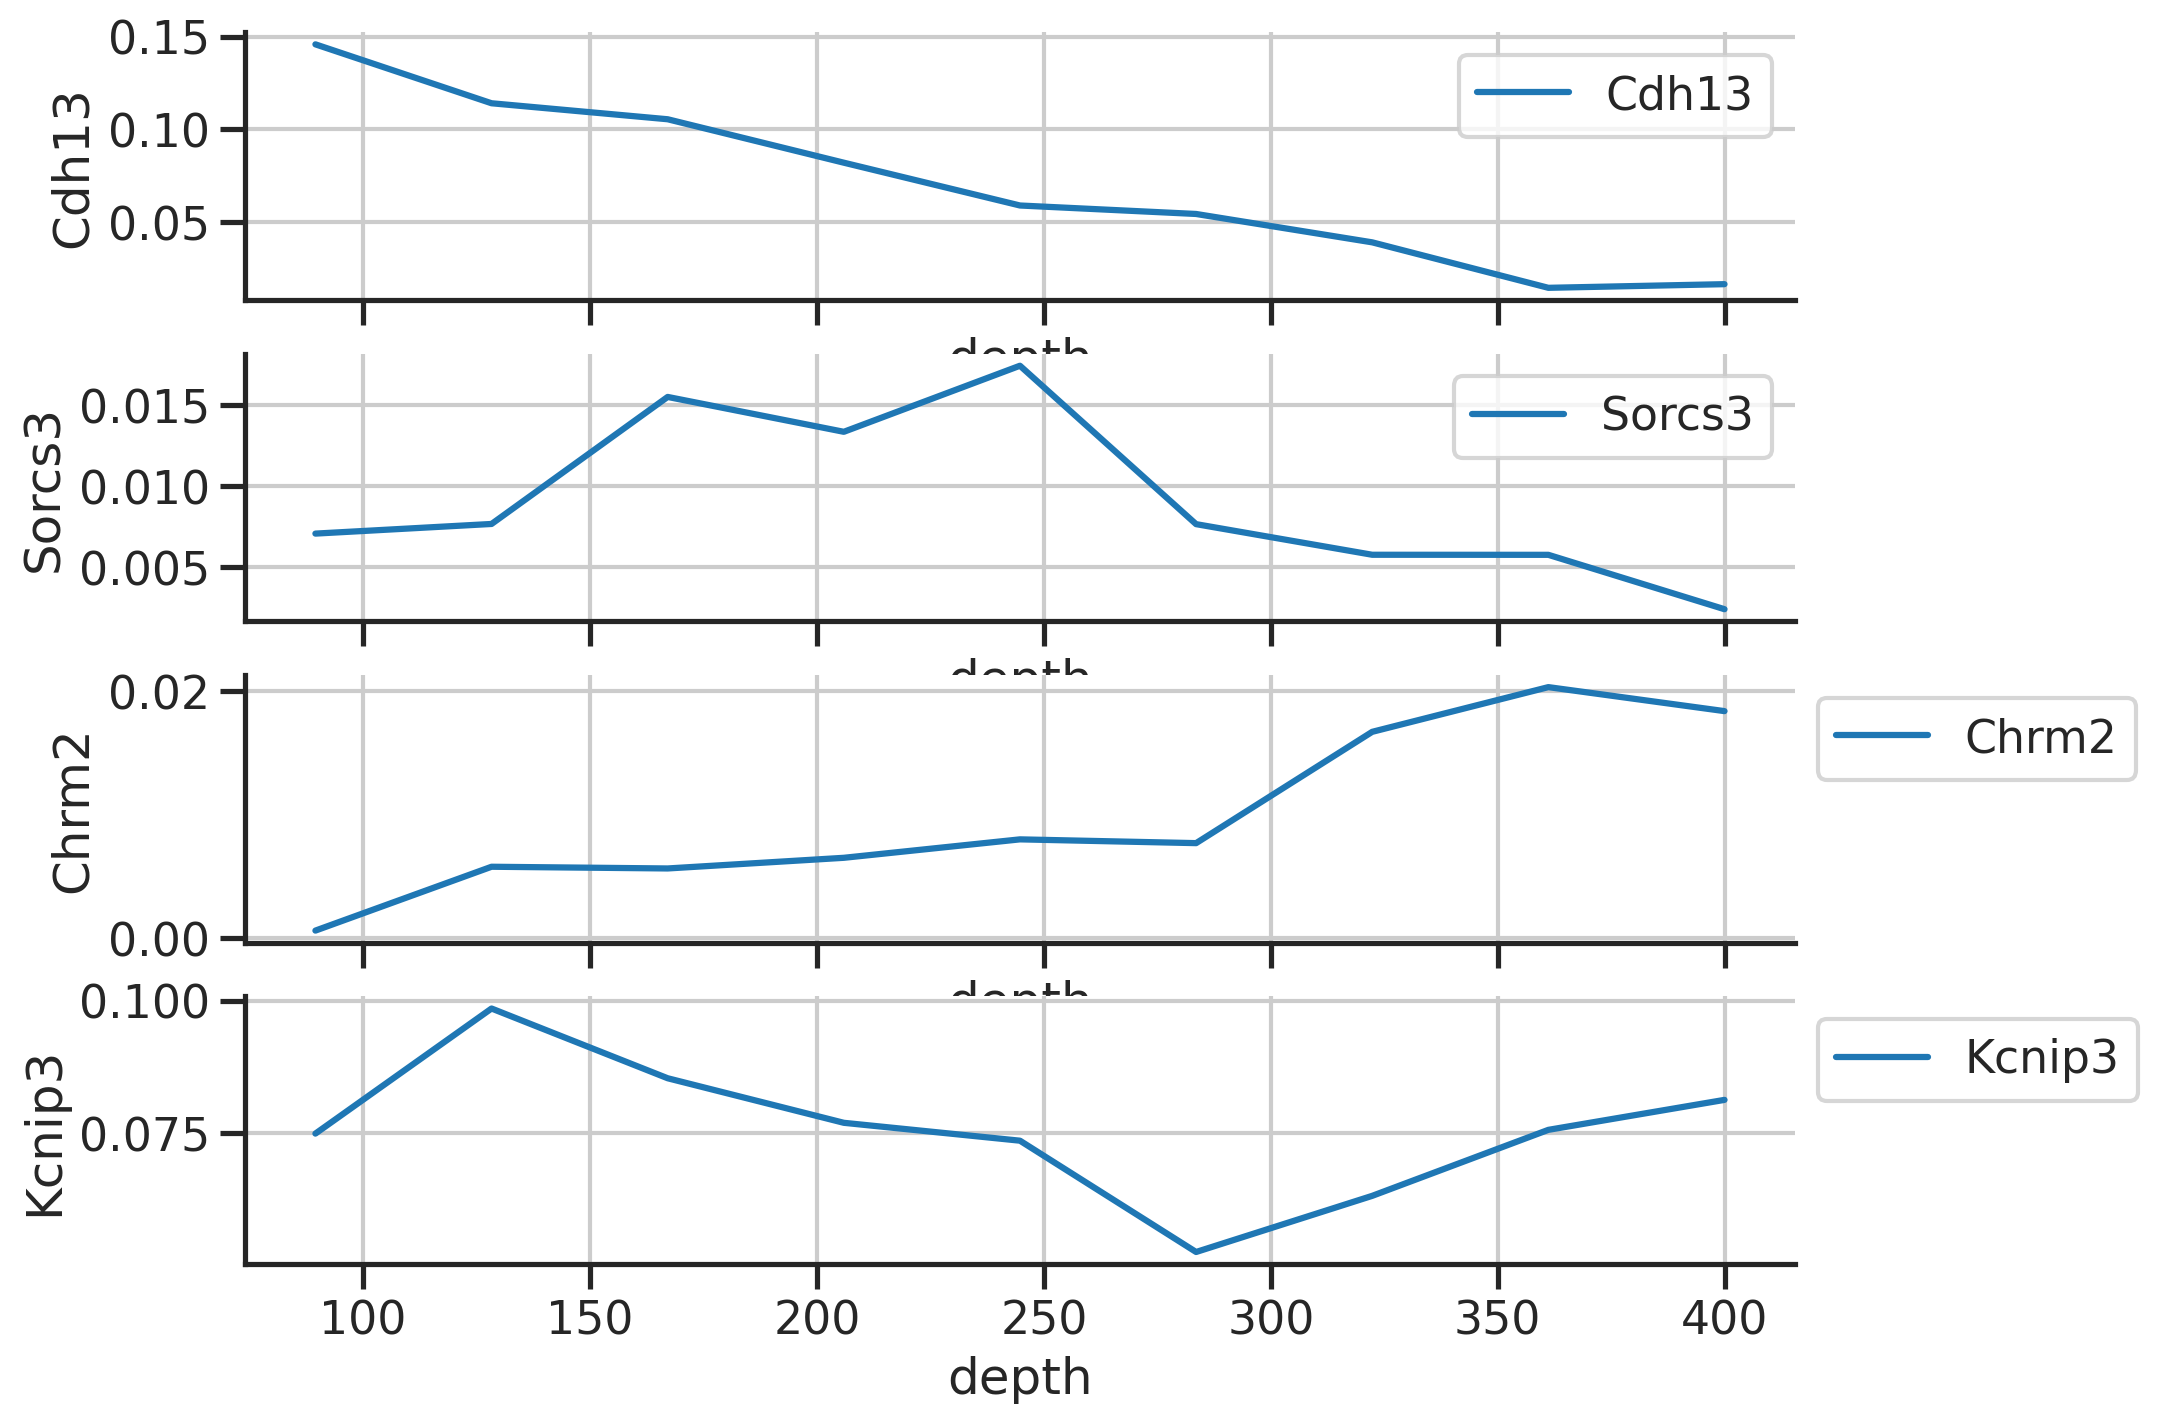

In [13]:
easigenes = ['Cdh13', 'Sorcs3', 'Chrm2', 'Kcnip3']
fig, axs = plt.subplots(len(easigenes), 1, figsize=(10,2*len(easigenes)), sharex=True)
for col, ax in zip(easigenes, axs): #metasub_typefrac_perbin: 
    ax.plot(db0[1:], lnorm_mean_p0[col].values, label=col) #, color=palette[col])
    ax.legend(bbox_to_anchor=(1,1))
    sns.despine(ax=ax)
    ax.set_xlabel('depth')
    ax.set_ylabel(col)

Text(0, 0.5, 'norm expr')

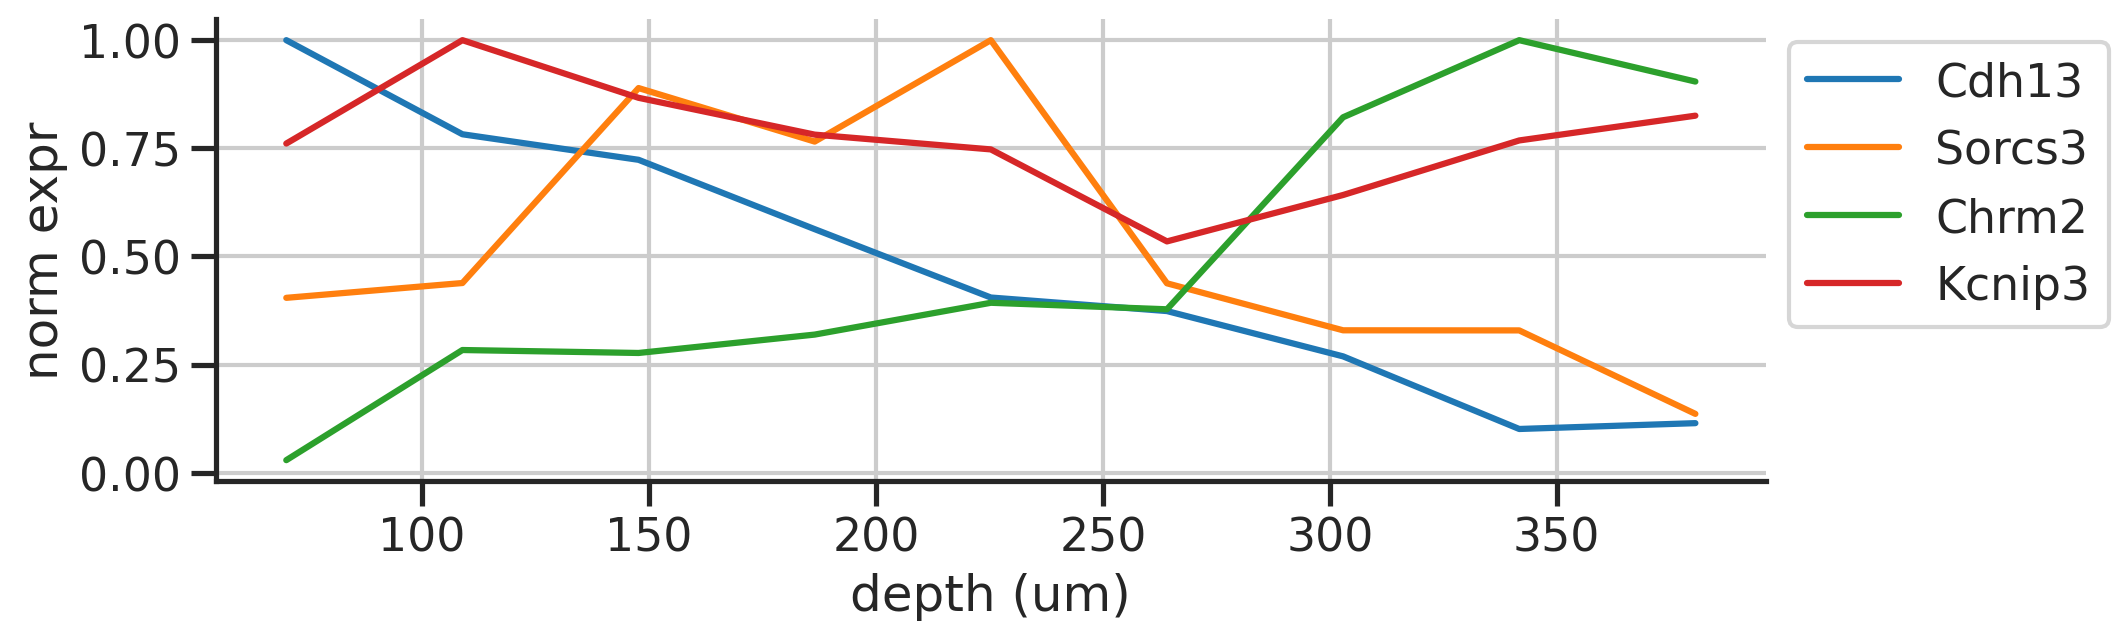

In [14]:
gns = ['Cdh13', 'Sorcs3', 'Chrm2', 'Kcnip3']
fig, ax = plt.subplots(1, 1, figsize=(10,3), sharex=True)
for col in gns: #metasub_typefrac_perbin: 
    x = np.mean(np.vstack([db0[:-1], db0[1:]]), axis=0)
    y = lnorm_mean_p0[col].values
    y = y/np.max(y)
    ax.plot(x, y, label=col) #, color=palette[col])
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_xlabel('depth (um)')
ax.set_ylabel('norm expr')
# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_lineq.pdf')

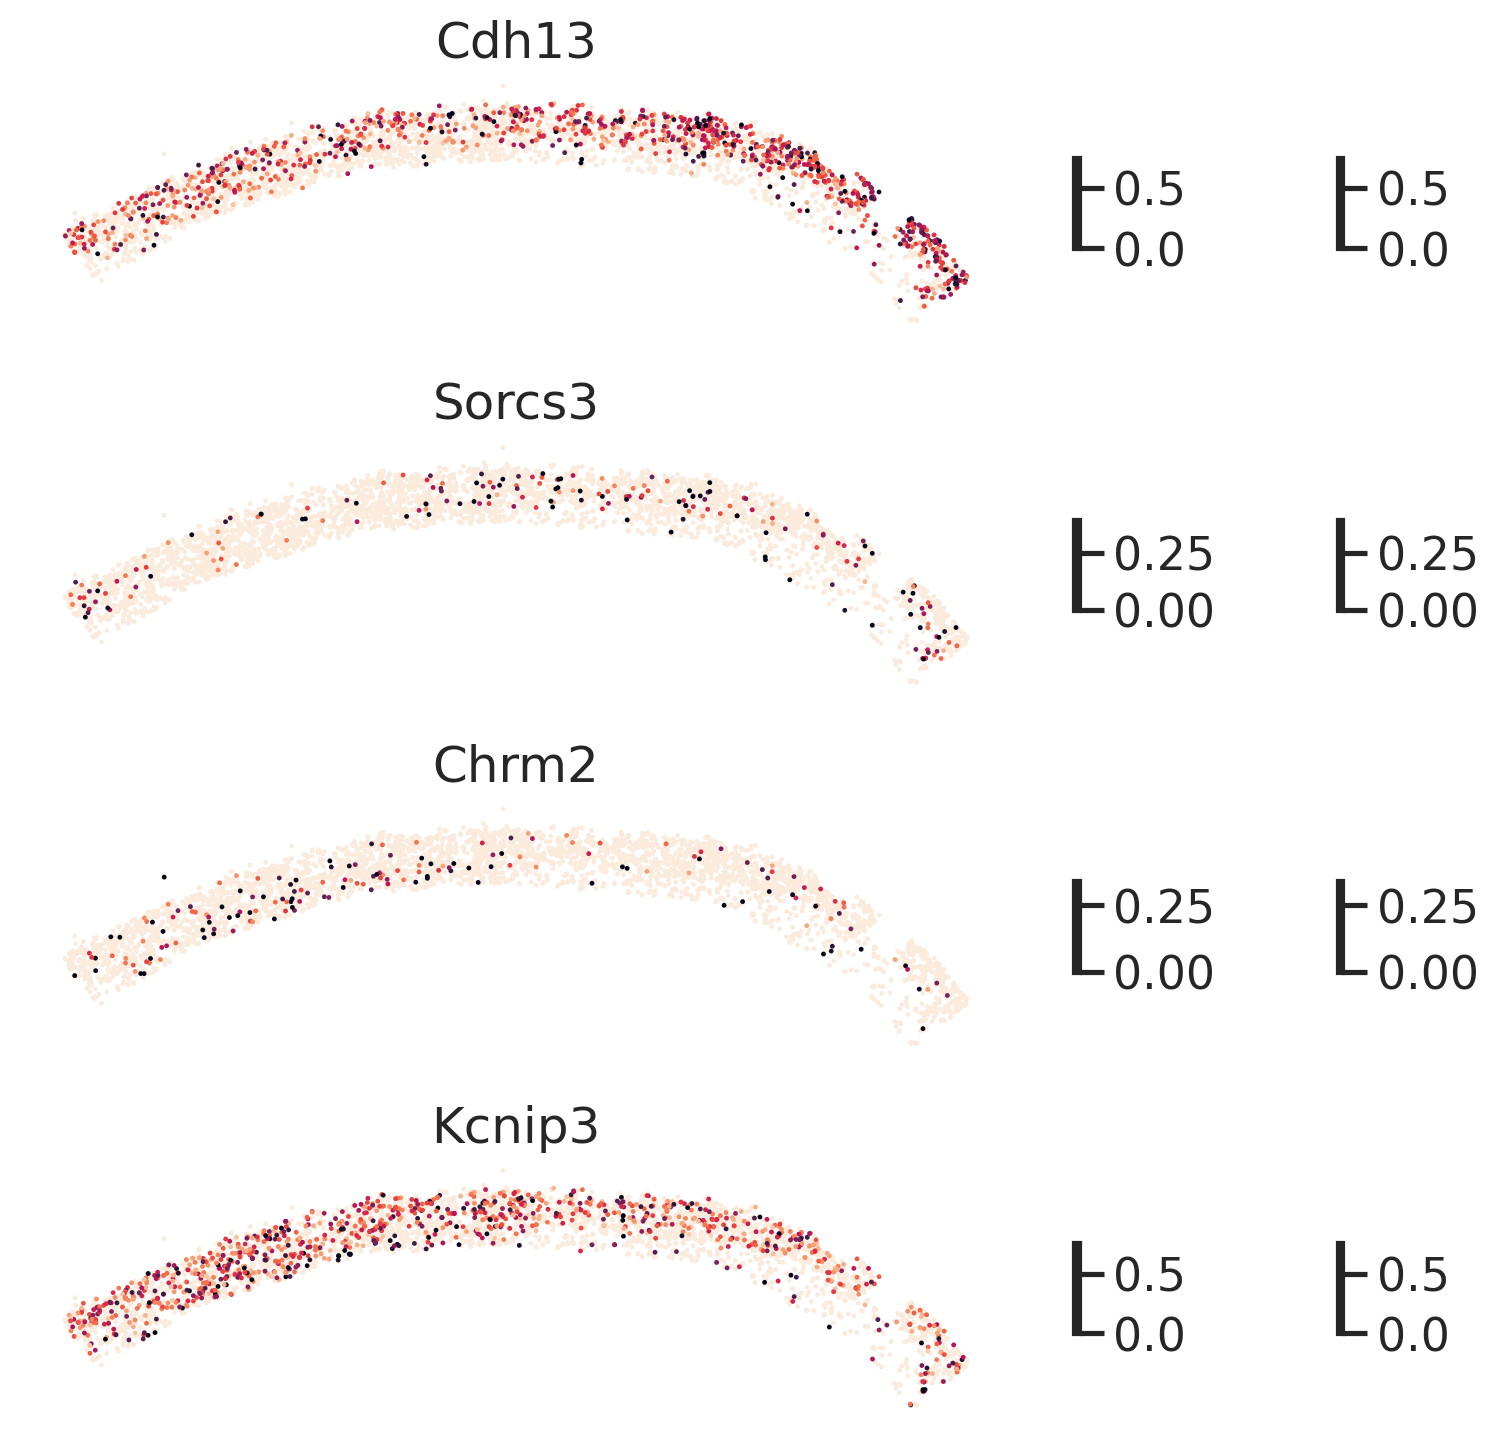

In [15]:
# umap and coordinates

theta = 40
fig, axs = plt.subplots(len(gns),1,figsize=(2*5,3*3))
for i, gn in enumerate(gns):
    x, y, g = utils_merfish.get_xyg(adata_p0, gn, 'norm')
    xr, yr = rot2d(x, y, theta)
    # cond = x < 10000
    # x = x[cond]
    # y = y[cond]
    # g = g[cond]

    vmax = np.percentile(g, 99)
    vmin = np.percentile(g,  5)

    ax = axs[i]
    cond = g > 1e-5
    utils_merfish.st_scatter_ax(fig, ax, xr[~cond], yr[~cond], gexp=g[~cond], s=3, title=gn, vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    utils_merfish.st_scatter_ax(fig, ax, xr[cond], yr[cond], gexp=g[cond], s=3, title=gn, vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)

# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_insitu.pdf')
plt.show()

In [16]:
agenes_idx = basicu.get_index_from_array(adata_p0.var.index.values, agenes)
bgenes_idx = basicu.get_index_from_array(adata_p0.var.index.values, bgenes)
cgenes_idx = basicu.get_index_from_array(adata_p0.var.index.values, cgenes)
agenes_idx

array([367, 463,  33, 401, 369, 305, 185,  80,   2, 336, 205, 307,  69,
       424, 136, 457,  65,  60, 425, 413, 364, 262, 493,  35, 248, 357,
       428, 341,  76, 417, 160, 147, 115,  25, 481, 146, 317, 234,  81,
       236, 109, 420, 298, 426, 434, 155, 468, 219, 256, 218, 301, 447,
       358, 410, 373, 235, 416, 303, 343, 489, 214, 394, 241, 374])

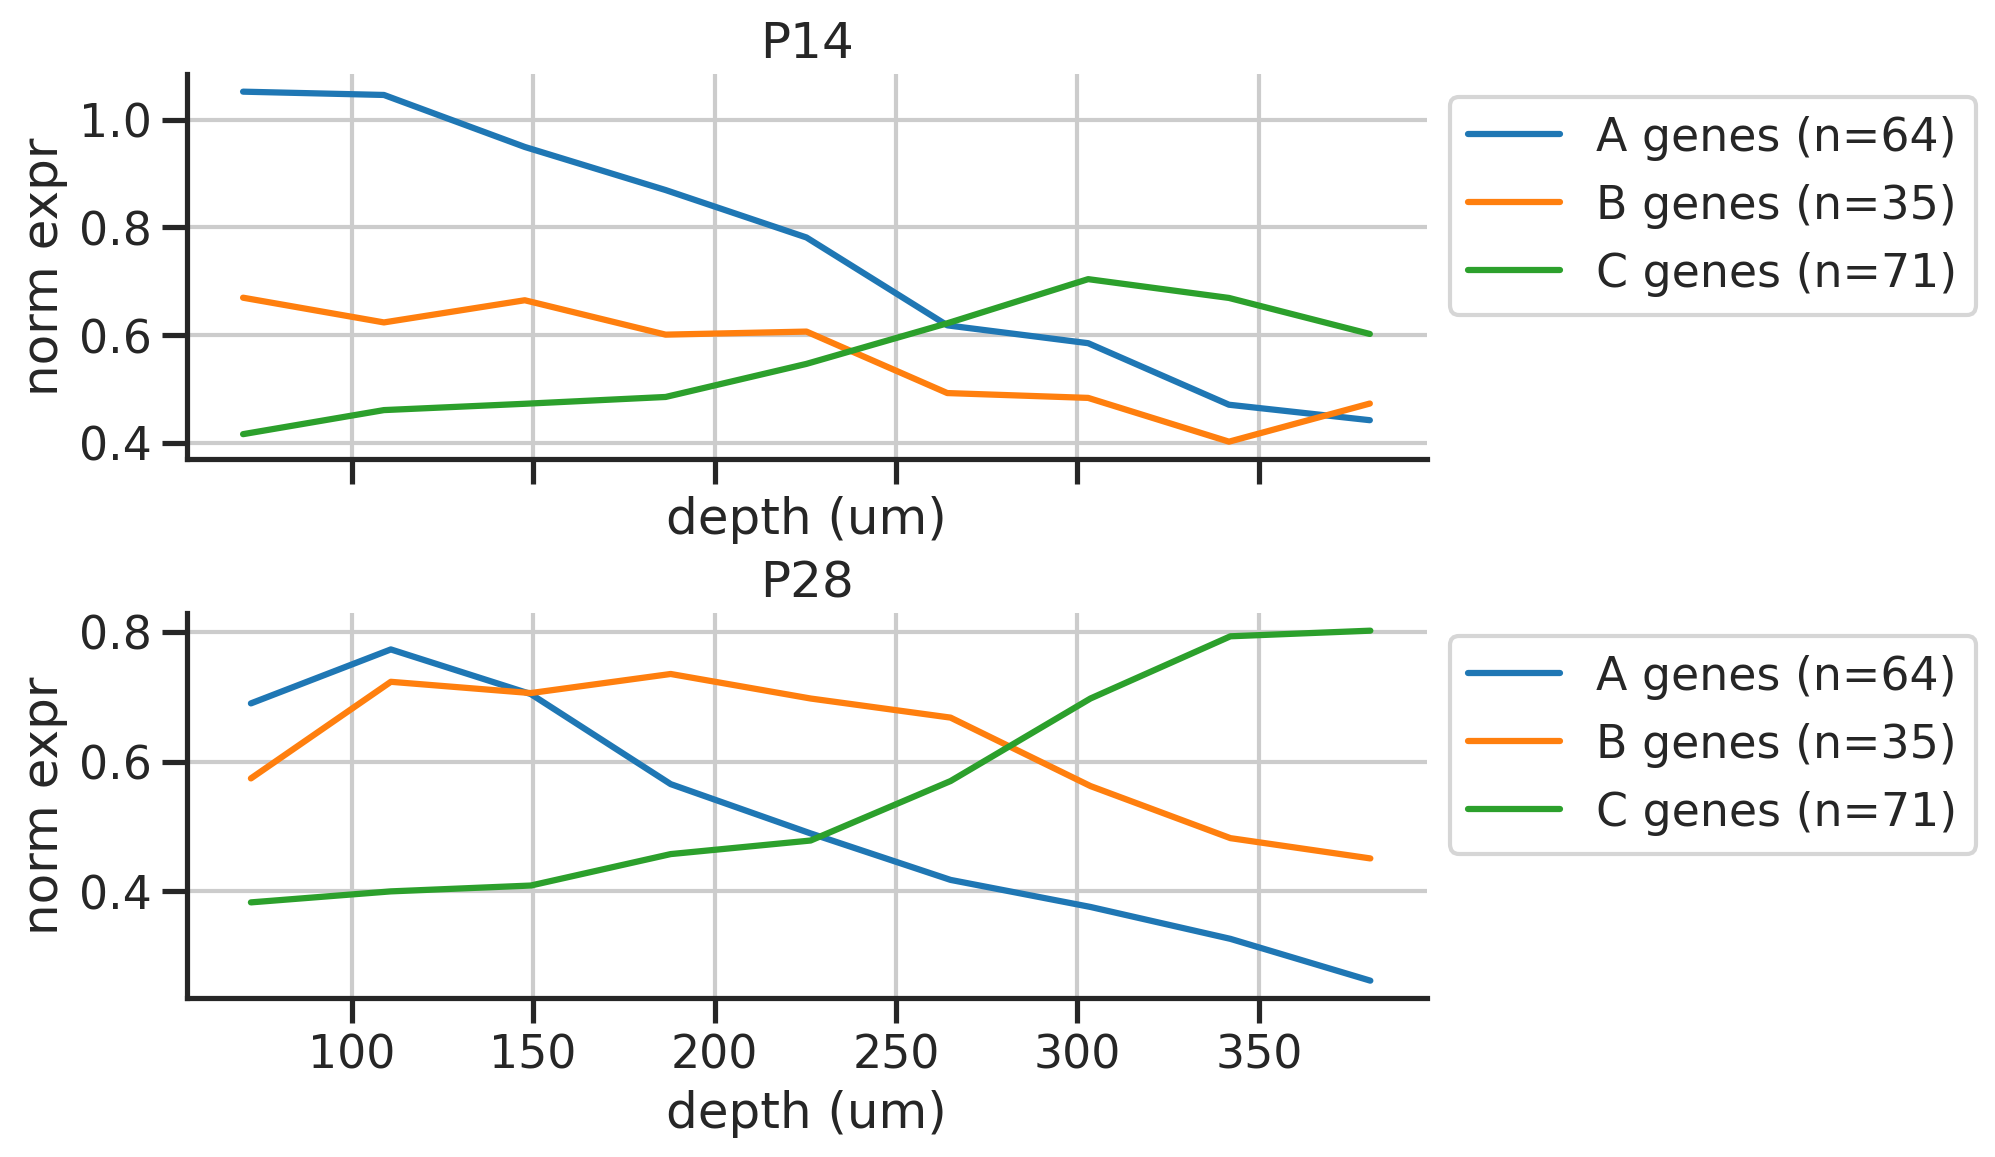

In [17]:
tmp = lnorm_mean_p1.iloc[:,agenes_idx].copy()
amax = np.max(tmp, axis=0)
amean_p1 = (tmp/amax).mean(axis=1)

tmp = lnorm_mean_p1.iloc[:,bgenes_idx].copy()
bmax = np.max(tmp, axis=0)
bmean_p1 = (tmp/bmax).mean(axis=1)

tmp = lnorm_mean_p1.iloc[:,cgenes_idx].copy()
cmax = np.max(tmp, axis=0)
cmean_p1 = (tmp/cmax).mean(axis=1)

# all relative to P28 
tmp = lnorm_mean_p0.iloc[:,agenes_idx].copy()
amean_p0 = (tmp/amax).mean(axis=1)

tmp = lnorm_mean_p0.iloc[:,bgenes_idx].copy()
bmean_p0 = (tmp/bmax).mean(axis=1)

tmp = lnorm_mean_p0.iloc[:,cgenes_idx].copy()
cmean_p0 = (tmp/cmax).mean(axis=1)



gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
x0 = np.mean(np.vstack([db0[:-1], db0[1:]]), axis=0)
x1 = np.mean(np.vstack([db1[:-1], db1[1:]]), axis=0)

fig, axs = plt.subplots(2, 1, figsize=(8,3*2), sharex=True) # sharey=True)
ax = axs[0]
ax.plot(x0, amean_p0, label=gnames[0], color='C0', linestyle='-')
ax.plot(x0, bmean_p0, label=gnames[1], color='C1', linestyle='-')
ax.plot(x0, cmean_p0, label=gnames[2], color='C2', linestyle='-')
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('P14')
ax.set_xlabel('depth (um)')
ax.set_ylabel('norm expr')

ax = axs[1]
ax.plot(x1, amean_p1, label=gnames[0], color='C0', linestyle='-')
ax.plot(x1, bmean_p1, label=gnames[1], color='C1', linestyle='-')
ax.plot(x1, cmean_p1, label=gnames[2], color='C2', linestyle='-')
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('P28')
ax.set_xlabel('depth (um)')
ax.set_ylabel('norm expr')
fig.subplots_adjust(hspace=0.4)
# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_lineq_abc.pdf')

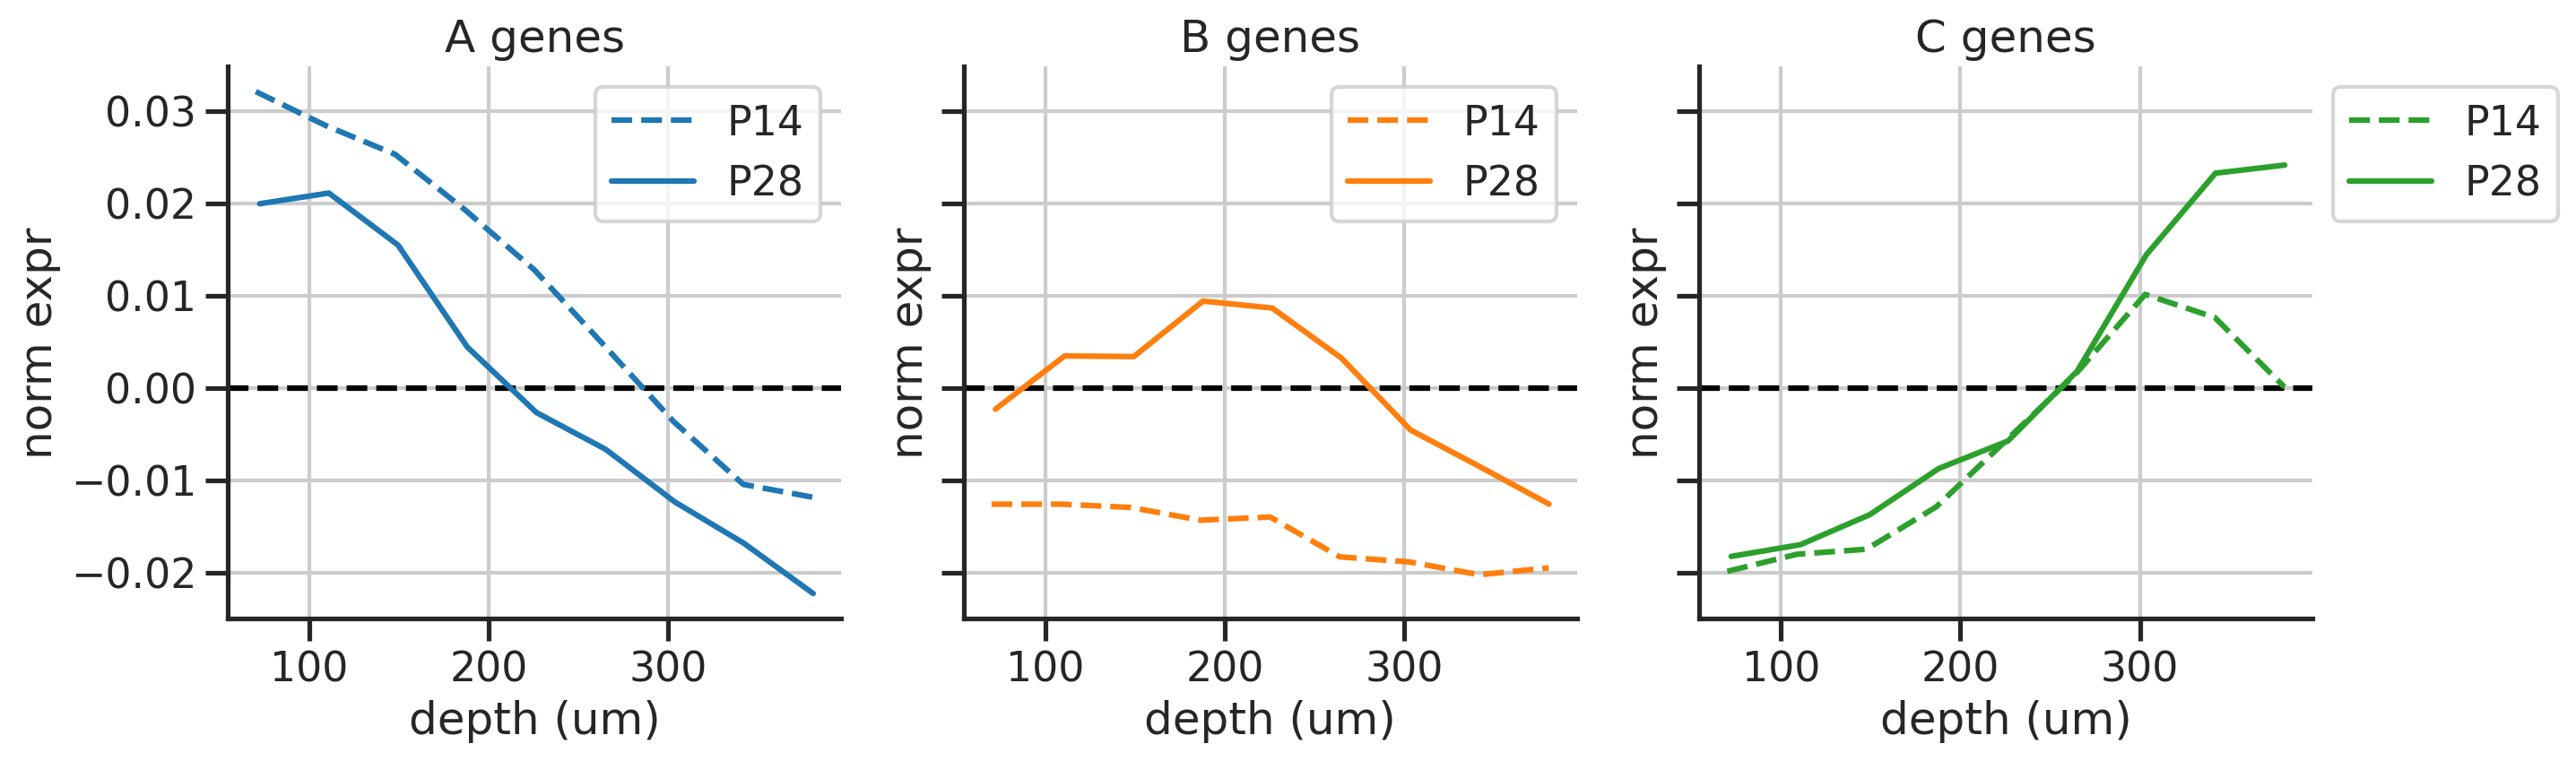

In [18]:
tmp = lnorm_mean_p1.iloc[:,agenes_idx].copy()
am = np.mean(tmp, axis=0) # across depth bins
amean_p1 = (tmp - am).mean(axis=1) # across genes

tmp = lnorm_mean_p1.iloc[:,bgenes_idx].copy()
bm = np.mean(tmp, axis=0)
bmean_p1 = (tmp - bm).mean(axis=1)

tmp = lnorm_mean_p1.iloc[:,cgenes_idx].copy()
cm = np.mean(tmp, axis=0)
cmean_p1 = (tmp - cm).mean(axis=1)

# all relative to P28 
tmp = lnorm_mean_p0.iloc[:,agenes_idx].copy()
amean_p0 = (tmp - am).mean(axis=1)

tmp = lnorm_mean_p0.iloc[:,bgenes_idx].copy()
bmean_p0 = (tmp - bm).mean(axis=1)

tmp = lnorm_mean_p0.iloc[:,cgenes_idx].copy()
cmean_p0 = (tmp - cm).mean(axis=1)


gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
x0 = np.mean(np.vstack([db0[:-1], db0[1:]]), axis=0)
x1 = np.mean(np.vstack([db1[:-1], db1[1:]]), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(5*3,4), sharex=True, sharey=True)
ax = axs[0]
ax.plot(x0, amean_p0, label='P14', color='C0', linestyle='--')
ax.plot(x1, amean_p1, label='P28', color='C0', linestyle='-')
ax.axhline(color='k', linestyle='--', zorder=1)
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('A genes')
ax.set_xlabel('depth (um)')
ax.set_ylabel('norm expr')

ax = axs[1]
ax.plot(x0, bmean_p0, label='P14', color='C1', linestyle='--')
ax.plot(x1, bmean_p1, label='P28', color='C1', linestyle='-')
ax.axhline(color='k', linestyle='--', zorder=1)
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('B genes')
ax.set_xlabel('depth (um)')
ax.set_ylabel('norm expr')

ax = axs[2]
ax.plot(x0, cmean_p0, label='P14', color='C2', linestyle='--')
ax.plot(x1, cmean_p1, label='P28', color='C2', linestyle='-')
ax.axhline(color='k', linestyle='--', zorder=1)
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('C genes')
ax.set_xlabel('depth (um)')
ax.set_ylabel('norm expr')

fig.subplots_adjust(wspace=0.2)
# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_lineq_abc.pdf')

In [19]:
print(np.power(10, 0.01), np.power(10, -0.01))
print(np.power(10, 0.02), np.power(10, -0.02))
print(np.power(10, 0.03), np.power(10, -0.03))
print(np.power(10, 0.04), np.power(10, -0.04))

1.023292992280754 0.9772372209558107
1.0471285480508996 0.954992586021436
1.0715193052376064 0.933254300796991
1.096478196143185 0.9120108393559098


In [20]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [21]:
tmp = lnorm_mean_p1.iloc[:,agenes_idx].copy()
am = np.mean(tmp, axis=0) # across depth bins
amean_p1 = (tmp - am).mean(axis=1) # across genes

tmp = lnorm_mean_p1.iloc[:,bgenes_idx].copy()
bm = np.mean(tmp, axis=0)
bmean_p1 = (tmp - bm).mean(axis=1)

tmp = lnorm_mean_p1.iloc[:,cgenes_idx].copy()
cm = np.mean(tmp, axis=0)
cmean_p1 = (tmp - cm).mean(axis=1)

# all relative to P28 
tmp = lnorm_mean_p0.iloc[:,agenes_idx].copy()
amean_p0 = (tmp - am).mean(axis=1)

tmp = lnorm_mean_p0.iloc[:,bgenes_idx].copy()
bmean_p0 = (tmp - bm).mean(axis=1)

tmp = lnorm_mean_p0.iloc[:,cgenes_idx].copy()
cmean_p0 = (tmp - cm).mean(axis=1)


# sem
tmp2 = lnorm_sem_p0.iloc[:,agenes_idx].copy()
asem_p0 = tmp2.mean(axis=1)

tmp2 = lnorm_sem_p0.iloc[:,bgenes_idx].copy()
bsem_p0 = tmp2.mean(axis=1)

tmp2 = lnorm_sem_p0.iloc[:,cgenes_idx].copy()
csem_p0 = tmp2.mean(axis=1)

# sem
tmp2 = lnorm_sem_p1.iloc[:,agenes_idx].copy()
asem_p1 = tmp2.mean(axis=1)

tmp2 = lnorm_sem_p1.iloc[:,bgenes_idx].copy()
bsem_p1 = tmp2.mean(axis=1)

tmp2 = lnorm_sem_p1.iloc[:,cgenes_idx].copy()
csem_p1 = tmp2.mean(axis=1)

# std 
tmp2 = lnorm_std_p0.iloc[:,agenes_idx].copy()
astd_p0 = tmp2.mean(axis=1)

tmp2 = lnorm_std_p0.iloc[:,bgenes_idx].copy()
bstd_p0 = tmp2.mean(axis=1)

tmp2 = lnorm_std_p0.iloc[:,cgenes_idx].copy()
cstd_p0 = tmp2.mean(axis=1)

# std
tmp2 = lnorm_std_p1.iloc[:,agenes_idx].copy()
astd_p1 = tmp2.mean(axis=1)

tmp2 = lnorm_std_p1.iloc[:,bgenes_idx].copy()
bstd_p1 = tmp2.mean(axis=1)

tmp2 = lnorm_std_p1.iloc[:,cgenes_idx].copy()
cstd_p1 = tmp2.mean(axis=1)

# std
_, aps = stats.ttest_ind_from_stats(amean_p0.values, astd_p0.values, n0.values, 
                                    amean_p1.values, astd_p1.values, n1.values,)

_, bps = stats.ttest_ind_from_stats(bmean_p0.values, bstd_p0.values, n0.values, 
                                    bmean_p1.values, bstd_p1.values, n1.values,)

_, cps = stats.ttest_ind_from_stats(cmean_p0.values, cstd_p0.values, n0.values, 
                                    cmean_p1.values, cstd_p1.values, n1.values,)

arej, aqs, _, _ = multipletests(aps, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
brej, bqs, _, _ = multipletests(bps, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
crej, cqs, _, _ = multipletests(cps, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

arej, brej, crej

(array([False, False, False, False, False, False, False, False, False]),
 array([False,  True,  True,  True,  True,  True,  True, False, False]),
 array([False, False, False, False, False, False, False, False, False]))

In [22]:
aqs, aps
bqs, bps
cqs, cps

# bqs
# cqs

(array([0.99431192, 0.99431192, 0.89919132, 0.89919132, 0.99431192,
        0.99431192, 0.9417247 , 0.20654331, 0.19645063]),
 array([0.89865654, 0.8618793 , 0.39964059, 0.37050811, 0.99431192,
        0.95417705, 0.52318039, 0.04589851, 0.02182785]))

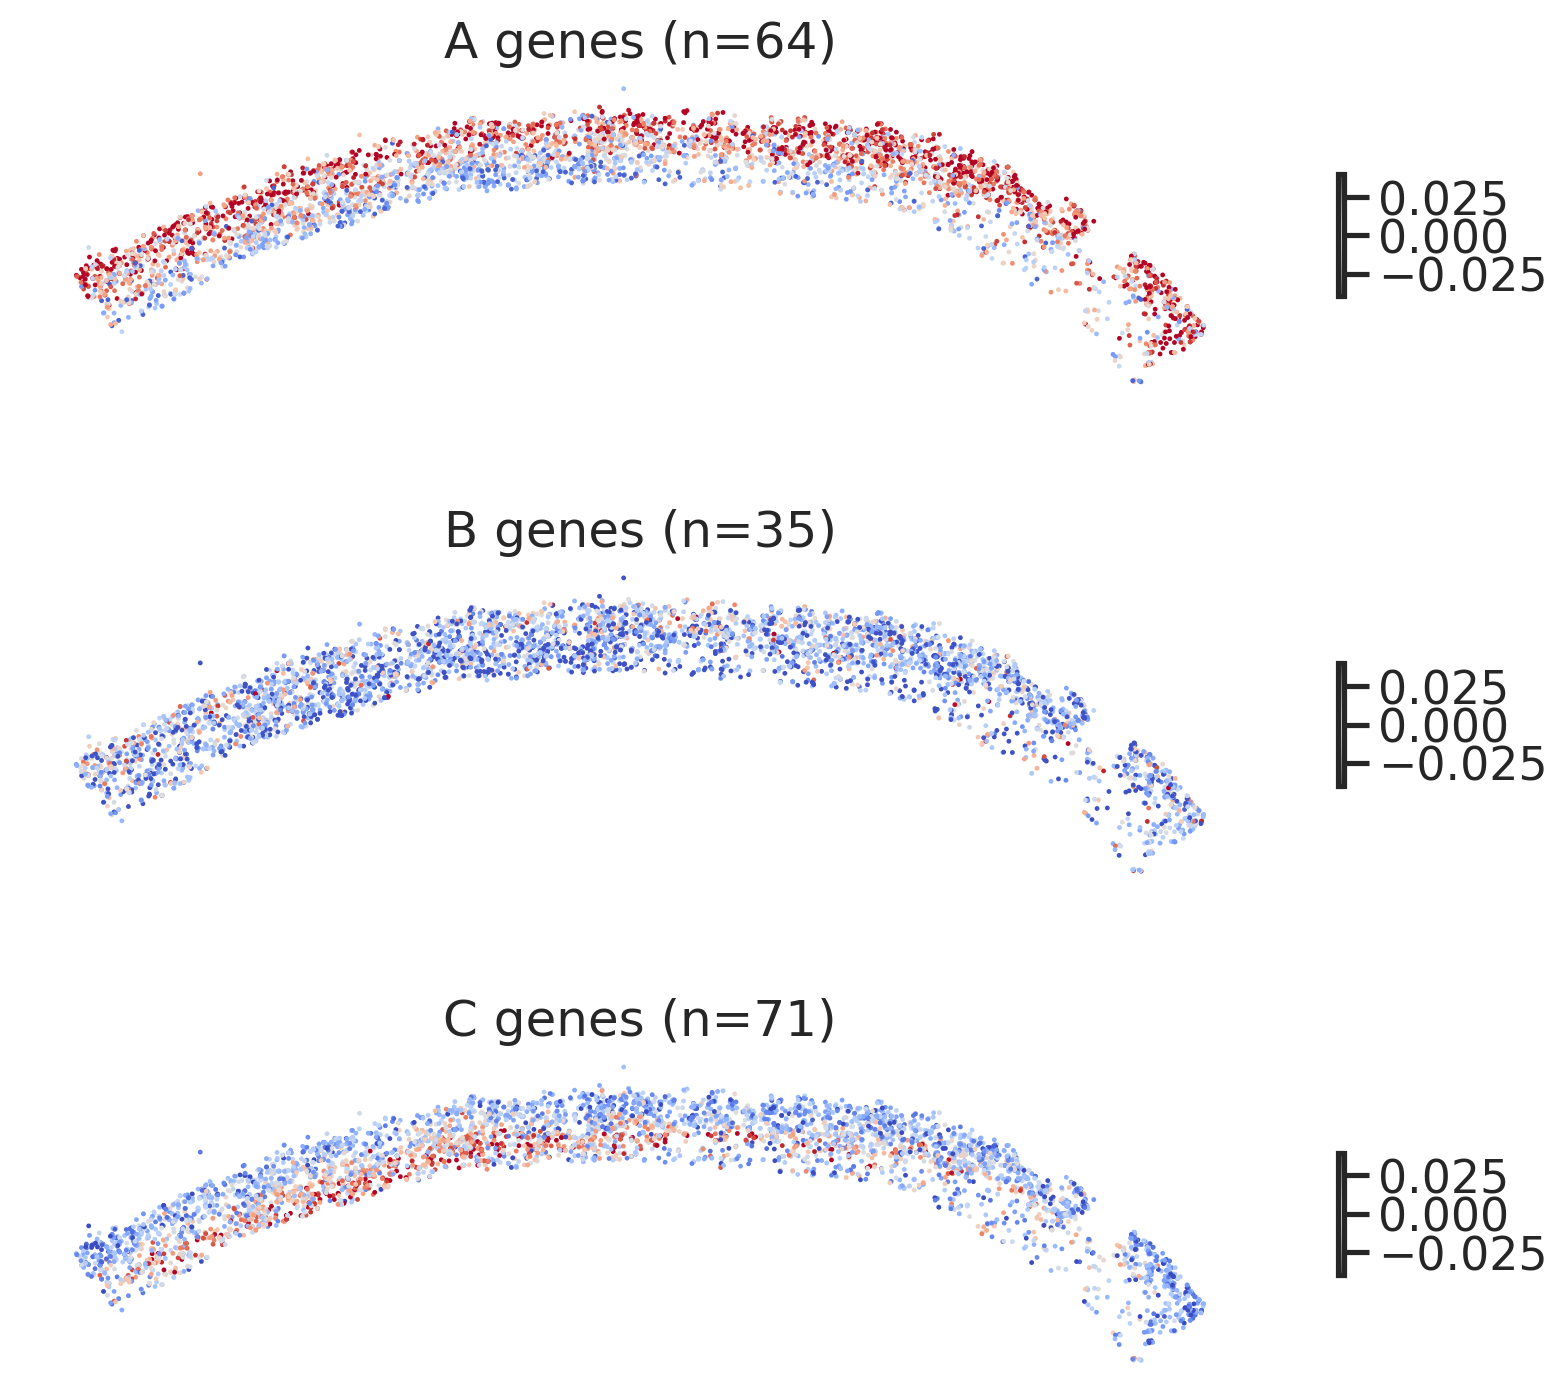

In [23]:
adata = adata_p0
x, y, _ = utils_merfish.get_xyg(adata, 'Cdh13', 'norm')
xr, yr = rot2d(x, y, theta)
                                
fig, axs = plt.subplots(3,1,figsize=(2*5,3*3))
ax = axs[0]
gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
for i, (_idx, _baseline) in enumerate(zip([agenes_idx, bgenes_idx, cgenes_idx], 
                                        [am, bm, cm])):
    ax = axs[i]
    lnorm_ = adata.layers['lnorm'][:,_idx].copy()
    g = (lnorm_ - np.array(_baseline).reshape(1,-1)).mean(axis=1) 
    gn = gnames[i]
    # vmax = np.percentile(g, 95)
    # vmin = np.percentile(g,  0)
    vmax = +0.04 # np.percentile(g, 95)
    vmin = -0.04 # np.percentile(g,  0)
    utils_merfish.st_scatter_ax(fig, ax, xr, yr, gexp=g, s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)
    # cond = g > 0.1
    # utils_merfish.st_scatter_ax(fig, ax, xr[~cond], yr[~cond], gexp=g[~cond], s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)
    # utils_merfish.st_scatter_ax(fig, ax, xr[cond], yr[cond], gexp=g[cond], s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)

# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_insitu_abc_p14.pdf')
plt.show()

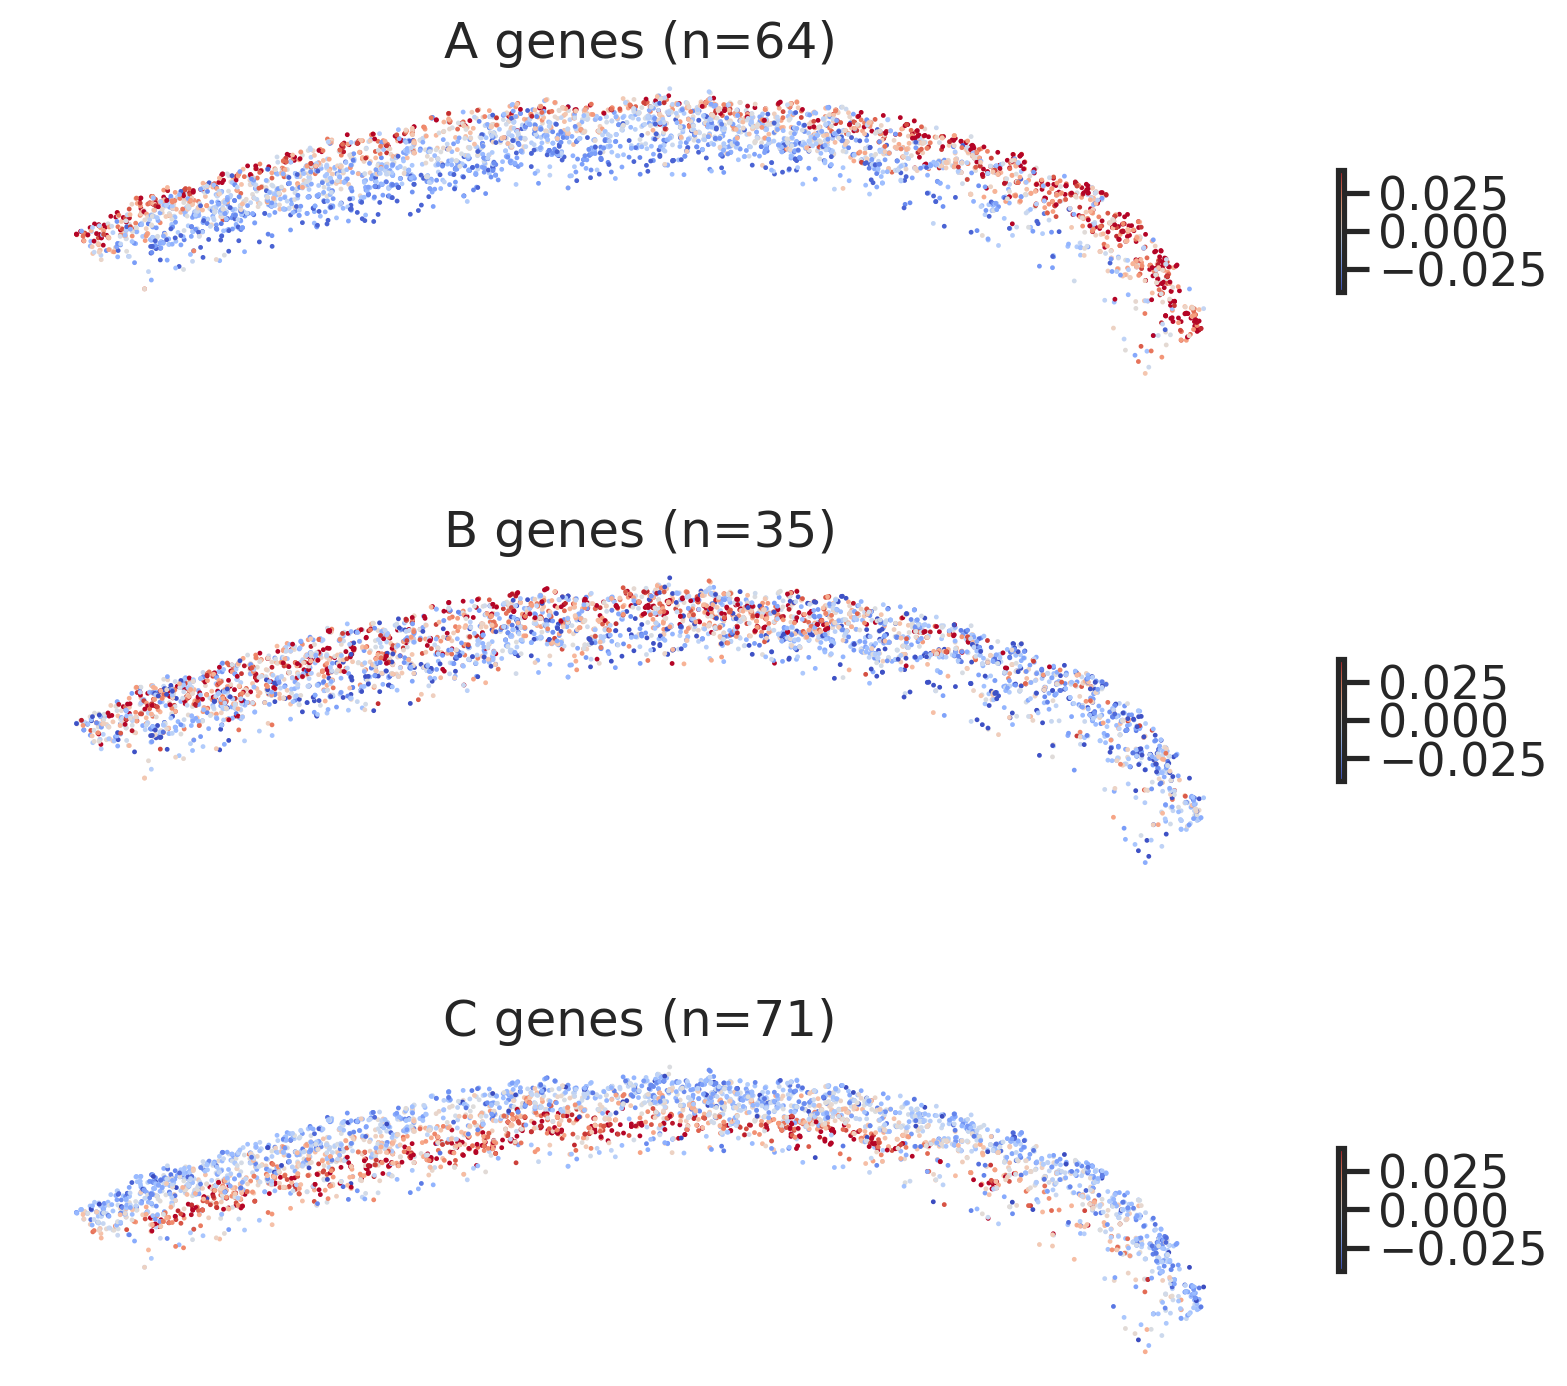

In [24]:
adata = adata_p1
x, y, _ = utils_merfish.get_xyg(adata, 'Cdh13', 'norm')
xr, yr = rot2d(x, y, theta)
                                
fig, axs = plt.subplots(3,1,figsize=(2*5,3*3))
ax = axs[0]
gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
for i, (_idx, _baseline) in enumerate(zip([agenes_idx, bgenes_idx, cgenes_idx], 
                                        [am, bm, cm])):
    ax = axs[i]
    lnorm_ = adata.layers['lnorm'][:,_idx].copy()
    g = (lnorm_ - np.array(_baseline).reshape(1,-1)).mean(axis=1) 
    gn = gnames[i]
    vmax = +0.04 # np.percentile(g, 95)
    vmin = -0.04 # np.percentile(g,  0)
    utils_merfish.st_scatter_ax(fig, ax, xr, yr, gexp=g, s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)
    # cond = g > 0.1
    # utils_merfish.st_scatter_ax(fig, ax, xr[~cond], yr[~cond], gexp=g[~cond], s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)
    # utils_merfish.st_scatter_ax(fig, ax, xr[cond], yr[cond], gexp=g[cond], s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)

# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_insitu_abc_p28.pdf')
plt.show()

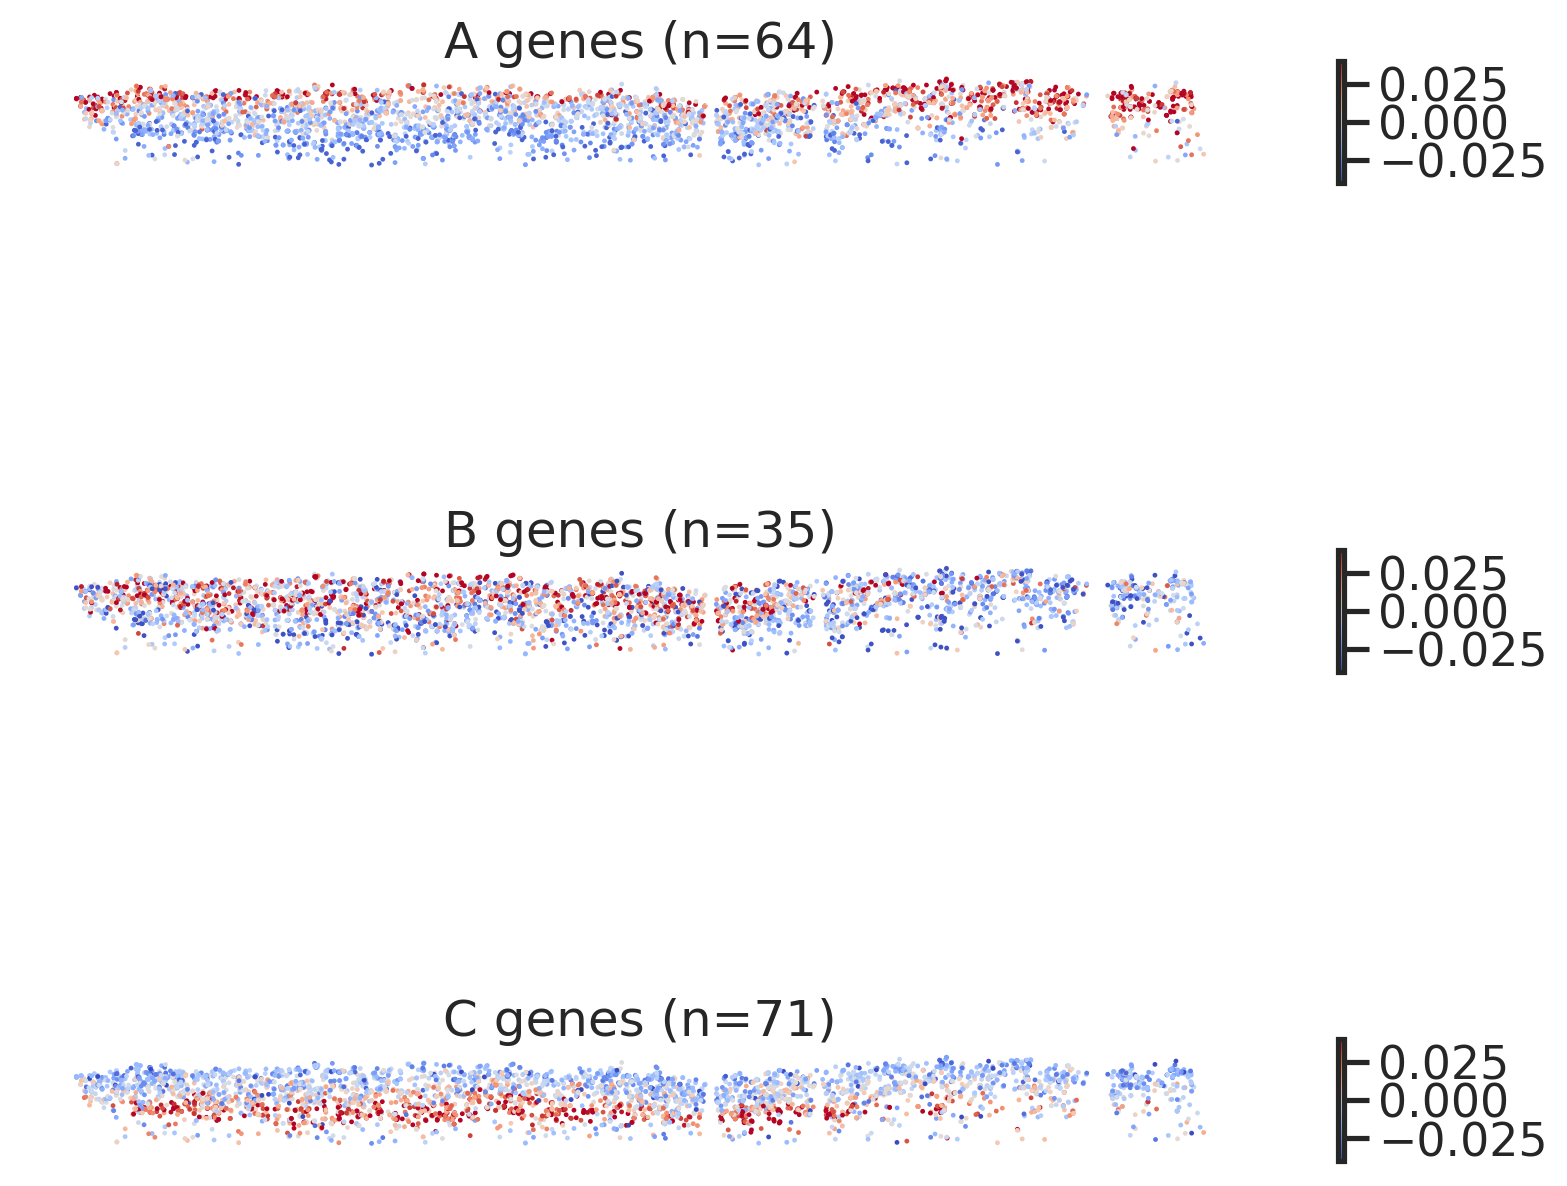

In [31]:
adata = adata_p1
depth = adata.obs['depth'].values
width = adata.obs['width'].values

# x, y, _ = utils_merfish.get_xyg(adata, 'Cdh13', 'norm')
# xr, yr = rot2d(x, y, theta)
                                
fig, axs = plt.subplots(3,1,figsize=(2*5,3*3))
ax = axs[0]
gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
for i, (_idx, _baseline) in enumerate(zip([agenes_idx, bgenes_idx, cgenes_idx], 
                                        [am, bm, cm])):
    ax = axs[i]
    lnorm_ = adata.layers['lnorm'][:,_idx].copy()
    g = (lnorm_ - np.array(_baseline).reshape(1,-1)).mean(axis=1) 
    gn = gnames[i]
    vmax = +0.04 # np.percentile(g, 95)
    vmin = -0.04 # np.percentile(g,  0)
    utils_merfish.st_scatter_ax(fig, ax, width, -depth, gexp=g, s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)
    # cond = g > 0.1
    # utils_merfish.st_scatter_ax(fig, ax, xr[~cond], yr[~cond], gexp=g[~cond], s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)
    # utils_merfish.st_scatter_ax(fig, ax, xr[cond], yr[cond], gexp=g[cond], s=3, title=gn, vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)

# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_insitu_abc_p28.pdf')
plt.show()

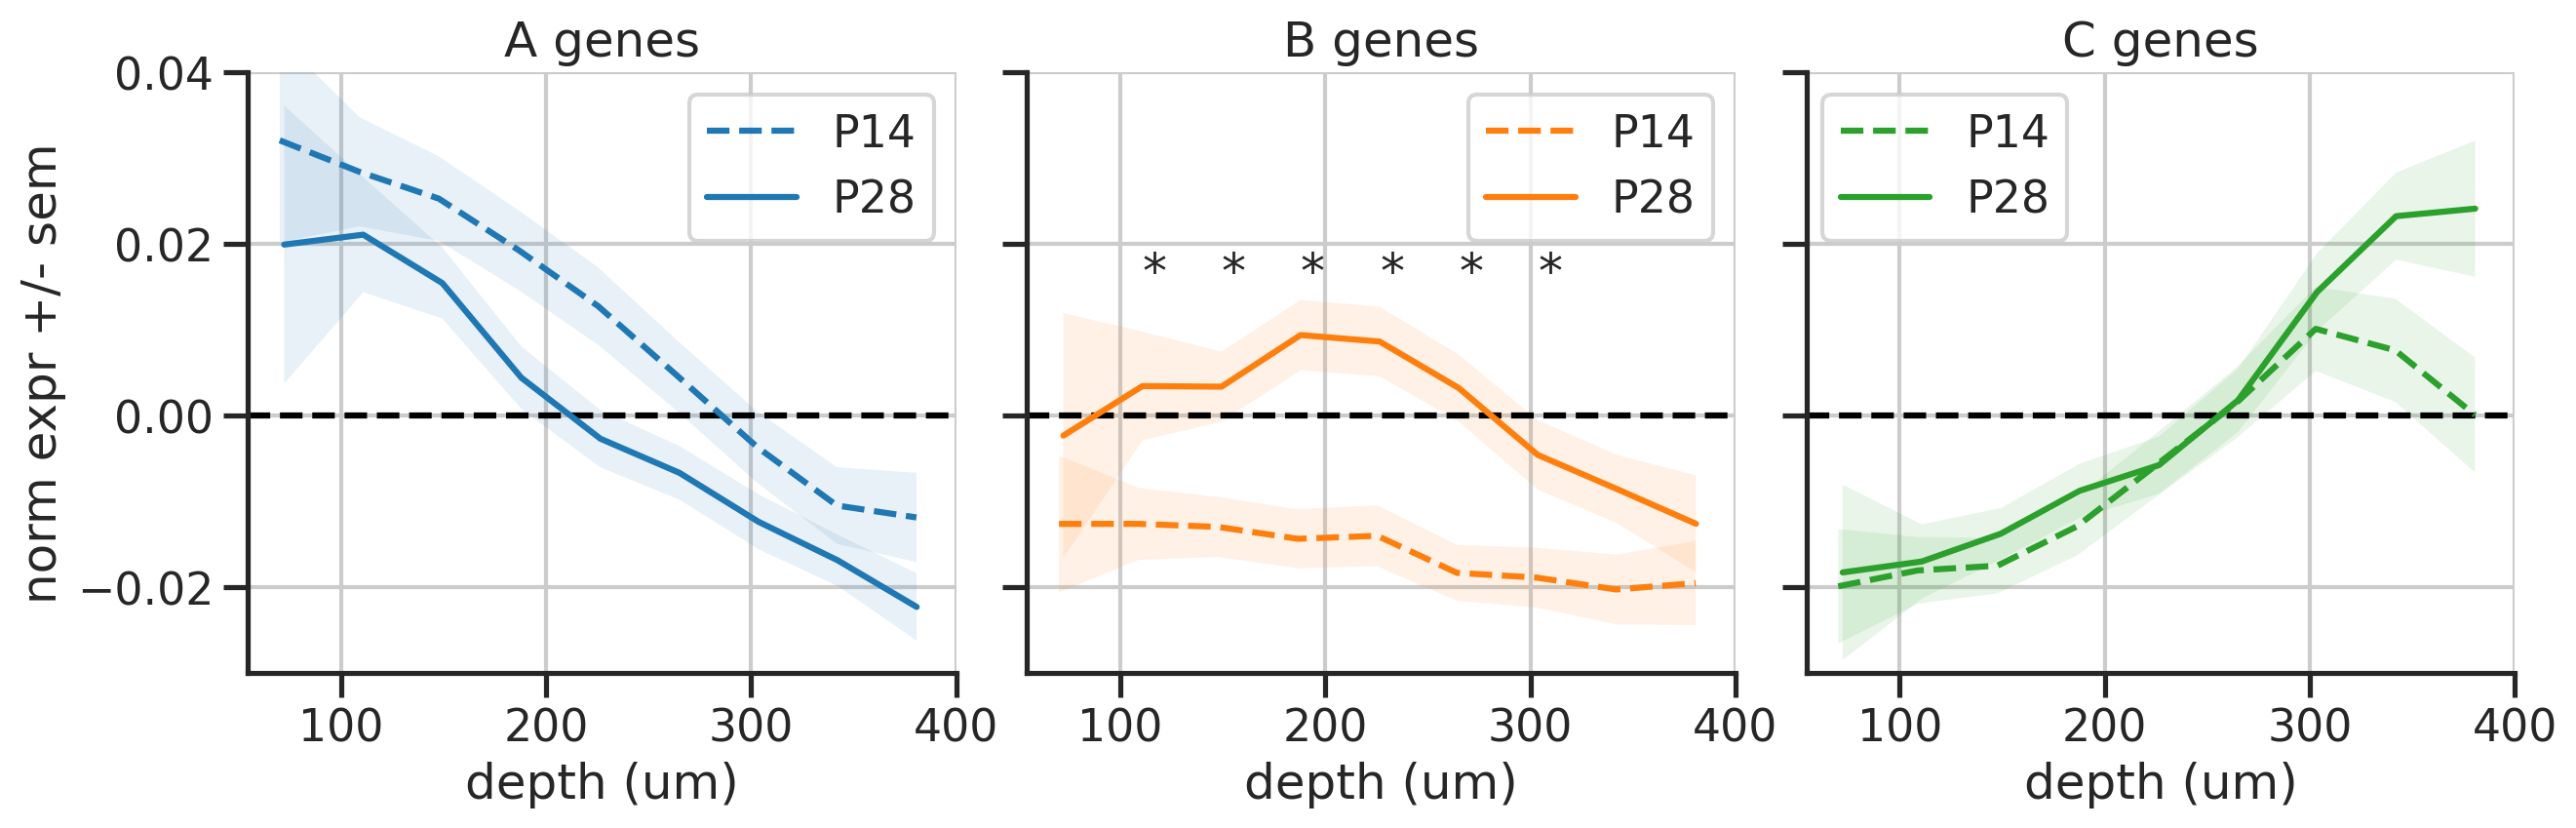

In [25]:
gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
x0 = np.mean(np.vstack([db0[:-1], db0[1:]]), axis=0)
x1 = np.mean(np.vstack([db1[:-1], db1[1:]]), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(5*3,4), sharex=True, sharey=True)
ax = axs[0]
ax.plot(x0, amean_p0, label='P14', color='C0', linestyle='--')
ax.fill_between(x0, amean_p0-asem_p0, amean_p0+asem_p0, color='C0', alpha=0.1, edgecolor='none')
ax.plot(x1, amean_p1, label='P28', color='C0', linestyle='-')
ax.fill_between(x1, amean_p1-asem_p1, amean_p1+asem_p1, color='C0', alpha=0.1, edgecolor='none')

ax.axhline(color='k', linestyle='--', zorder=1)
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('A genes')
ax.set_xlabel('depth (um)')
ax.set_ylabel('norm expr +/- sem')

ax = axs[1]
ax.plot(x0, bmean_p0, label='P14', color='C1', linestyle='--')
ax.fill_between(x0, bmean_p0-bsem_p0, bmean_p0+bsem_p0, color='C1', alpha=0.1, edgecolor='none')
ax.plot(x1, bmean_p1, label='P28', color='C1', linestyle='-')
ax.fill_between(x1, bmean_p1-bsem_p1, bmean_p1+bsem_p1, color='C1', alpha=0.1, edgecolor='none')
ax.axhline(color='k', linestyle='--', zorder=1)
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('B genes')
ax.set_xlabel('depth (um)')

ax = axs[2]
ax.errorbar(x0, cmean_p0, label='P14', color='C2', linestyle='--')
ax.fill_between(x0, cmean_p0-csem_p0, cmean_p0+csem_p0, color='C2', alpha=0.1, edgecolor='none')
ax.errorbar(x1, cmean_p1, label='P28', color='C2', linestyle='-')
ax.fill_between(x1, cmean_p1-csem_p1, cmean_p1+csem_p1, color='C2', alpha=0.1, edgecolor='none')
ax.axhline(color='k', linestyle='--', zorder=1)
    
ax.legend(bbox_to_anchor=(0.4,1))
sns.despine(ax=ax)
ax.set_title('C genes')
ax.set_xlabel('depth (um)')

ax.set_ylim([-0.03, 0.04])
for x1_, arej_, brej_, crej_ in zip(x1, arej, brej, crej):
    if arej_: axs[0].text(x1_, 0.015, '*')
    if brej_: axs[1].text(x1_, 0.015, '*')
    if crej_: axs[2].text(x1_, 0.015, '*')
    
ax.set_xlim(xmax=400)
fig.subplots_adjust(wspace=0.1)
# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_lineq_abc_v2.pdf')

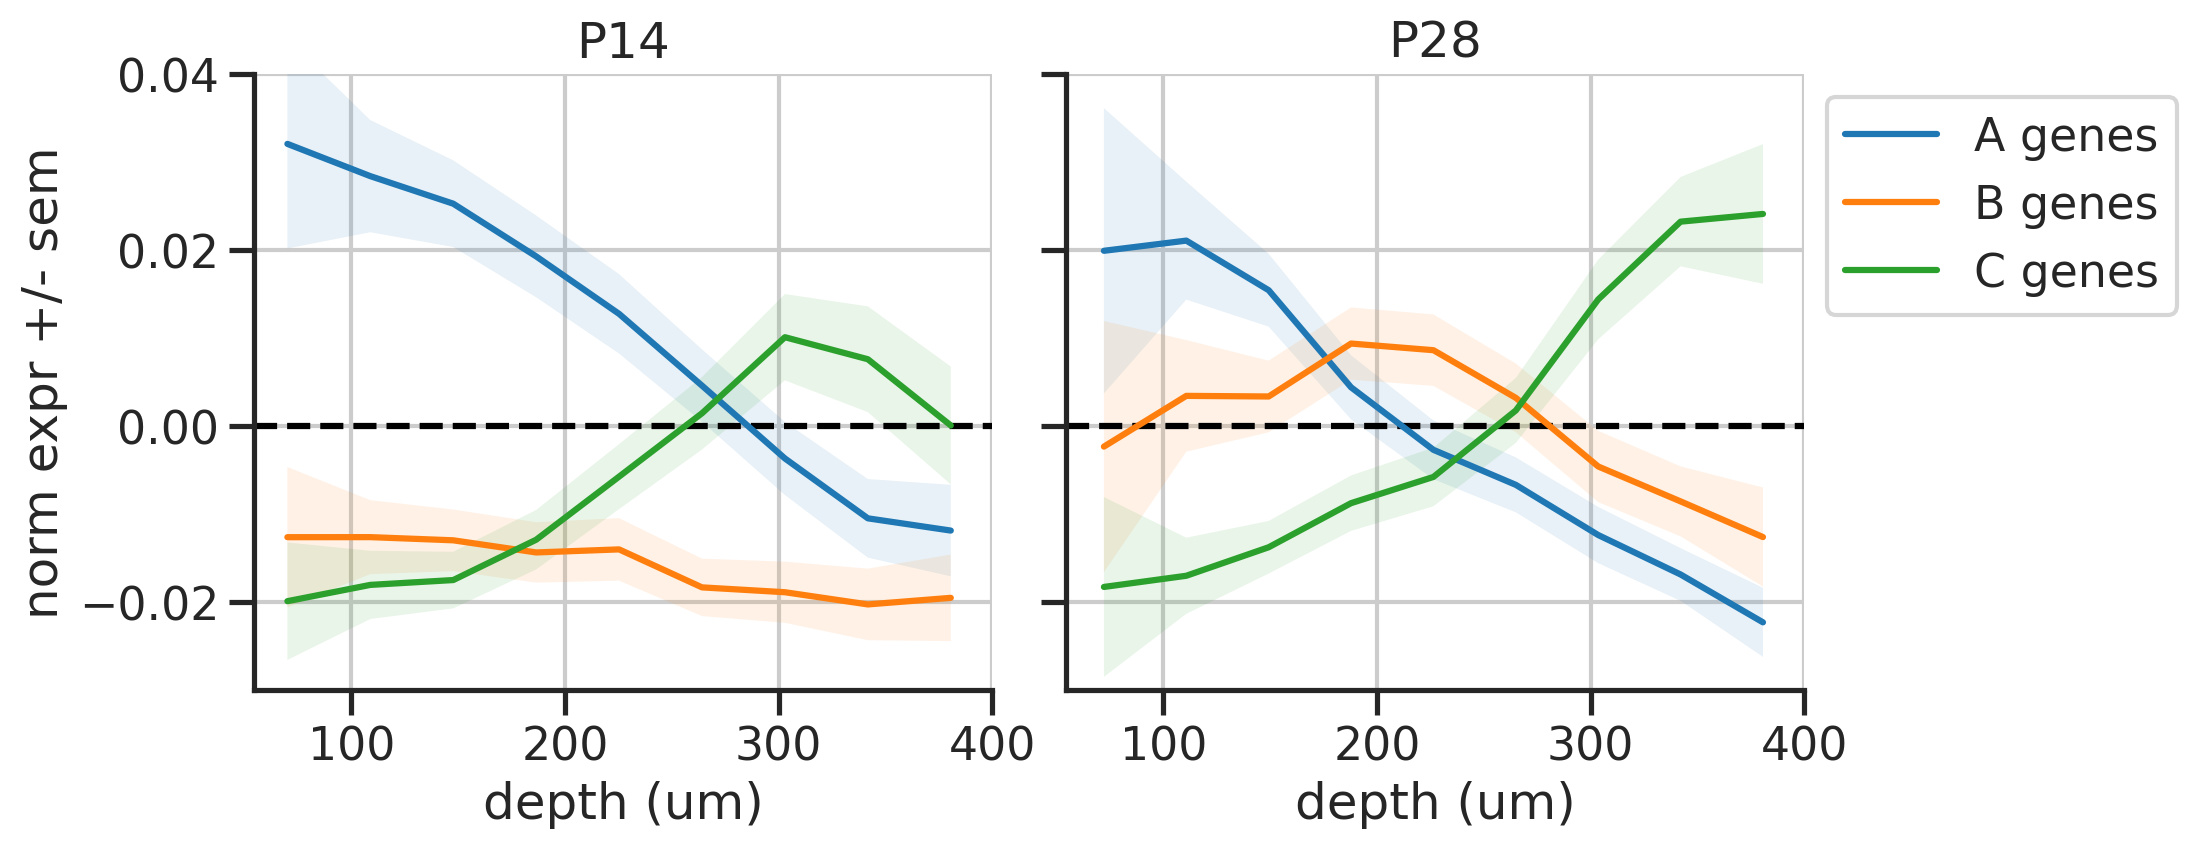

In [26]:

gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
x0 = np.mean(np.vstack([db0[:-1], db0[1:]]), axis=0)
x1 = np.mean(np.vstack([db1[:-1], db1[1:]]), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(5*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.plot(x0, amean_p0, label='A genes', color='C0', linestyle='-')
ax.fill_between(x0, amean_p0-asem_p0, amean_p0+asem_p0, color='C0', alpha=0.1, edgecolor='none')
ax.plot(x0, bmean_p0, label='B genes', color='C1', linestyle='-')
ax.fill_between(x0, bmean_p0-bsem_p0, bmean_p0+bsem_p0, color='C1', alpha=0.1, edgecolor='none')
ax.errorbar(x0, cmean_p0, label='C genes', color='C2', linestyle='-')
ax.fill_between(x0, cmean_p0-csem_p0, cmean_p0+csem_p0, color='C2', alpha=0.1, edgecolor='none')


ax.axhline(color='k', linestyle='--', zorder=1)
sns.despine(ax=ax)
ax.set_title('P14')
ax.set_xlabel('depth (um)')
ax.set_ylabel('norm expr +/- sem')

ax = axs[1]
ax.plot(x1, amean_p1, label='A genes', color='C0', linestyle='-')
ax.fill_between(x1, amean_p1-asem_p1, amean_p1+asem_p1, color='C0', alpha=0.1, edgecolor='none')
ax.plot(x1, bmean_p1, label='B genes', color='C1', linestyle='-')
ax.fill_between(x1, bmean_p1-bsem_p1, bmean_p1+bsem_p1, color='C1', alpha=0.1, edgecolor='none')
ax.errorbar(x1, cmean_p1, label='C genes', color='C2', linestyle='-')
ax.fill_between(x1, cmean_p1-csem_p1, cmean_p1+csem_p1, color='C2', alpha=0.1, edgecolor='none')
ax.axhline(color='k', linestyle='--', zorder=1)
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('P28')
ax.set_xlabel('depth (um)')


ax.set_ylim([-0.03, 0.04])
    
ax.set_xlim(xmax=400)
fig.subplots_adjust(wspace=0.1)
# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_lineq_abc_v3.pdf')